In [1]:
import numpy as np
#import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

#from astropy.modeling.models import Gaussian1D
#from astropy.convolution import convolve, Box1DKernel, Gaussian1DKernel

In [2]:
%matplotlib inline

In [18]:
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['font.size'] = 12
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 5
plt.rcParams['axes.labelsize'] = 15
# plt.rcParams['savefig.transparent'] = False
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.edgecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'
plt.rcParams['savefig.edgecolor'] = 'white'

# Some tutorialization

In [4]:
import emcee

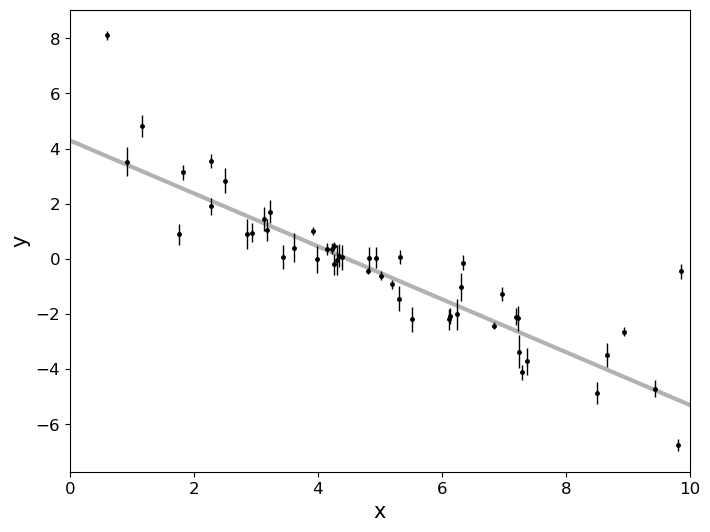

In [19]:
np.random.seed(123)

# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.5 * np.random.rand(N)
y = m_true * x + b_true
y += np.abs(f_true * y) * np.random.randn(N)
y += yerr * np.random.randn(N)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

Least-squares estimates:
m = -1.104 ± 0.016
b = 5.441 ± 0.091


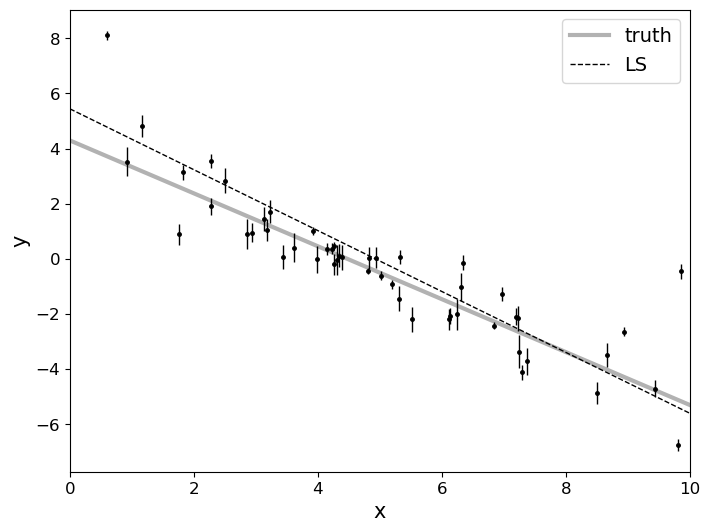

In [20]:
# a linear least squares fit:
A = np.vander(x, 2)
C = np.diag(yerr * yerr)
ATA = np.dot(A.T, A / (yerr**2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y / yerr**2))
print("Least-squares estimates:")
print("m = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0])))
print("b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

In [7]:
# a gaussian where the errors are underestimated by some amount
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

Maximum likelihood estimates:
m = -1.003
b = 4.528
f = 0.454


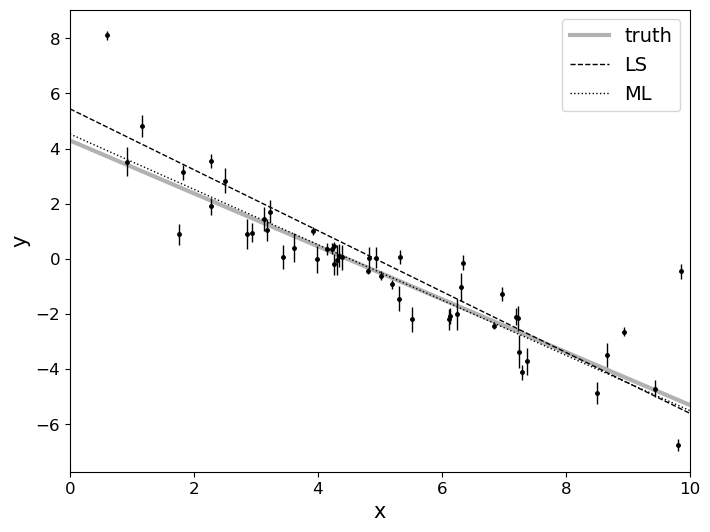

In [21]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([m_true, b_true, np.log(f_true)]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, b_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");


In [9]:
def log_prior(theta):
    m, b, log_f = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

In [10]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [26]:
pos

array([[-1.00285621,  4.52829088, -0.79046374],
       [-1.00285059,  4.52839104, -0.79048728],
       [-1.00295426,  4.52826795, -0.7904869 ],
       [-1.00298432,  4.52812296, -0.79061282],
       [-1.00306474,  4.52821301, -0.79040891],
       [-1.00309932,  4.52817306, -0.79029377],
       [-1.00303109,  4.52832104, -0.79058281],
       [-1.00306295,  4.52832538, -0.79055543],
       [-1.00297095,  4.52825423, -0.7904695 ],
       [-1.00306869,  4.52849952, -0.79044168],
       [-1.00311429,  4.52839655, -0.79056241],
       [-1.00298763,  4.52811832, -0.79057315],
       [-1.00298883,  4.52838814, -0.79042319],
       [-1.00302008,  4.52828418, -0.79058818],
       [-1.0030805 ,  4.52826823, -0.79033462],
       [-1.00297415,  4.52813799, -0.79040792],
       [-1.00304702,  4.5282466 , -0.79037916],
       [-1.00290542,  4.52840742, -0.79052425],
       [-1.00303944,  4.52834742, -0.79034278],
       [-1.00305643,  4.52829573, -0.79055096],
       [-1.00312814,  4.52839554, -0.790

In [11]:
pos = soln.x + 1e-4 * np.random.randn(32, 3) # from the minimization
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr)
)
sampler.run_mcmc(pos, 5000, progress=True);

100%|█████████████████████████████████████| 5000/5000 [00:01<00:00, 2713.42it/s]


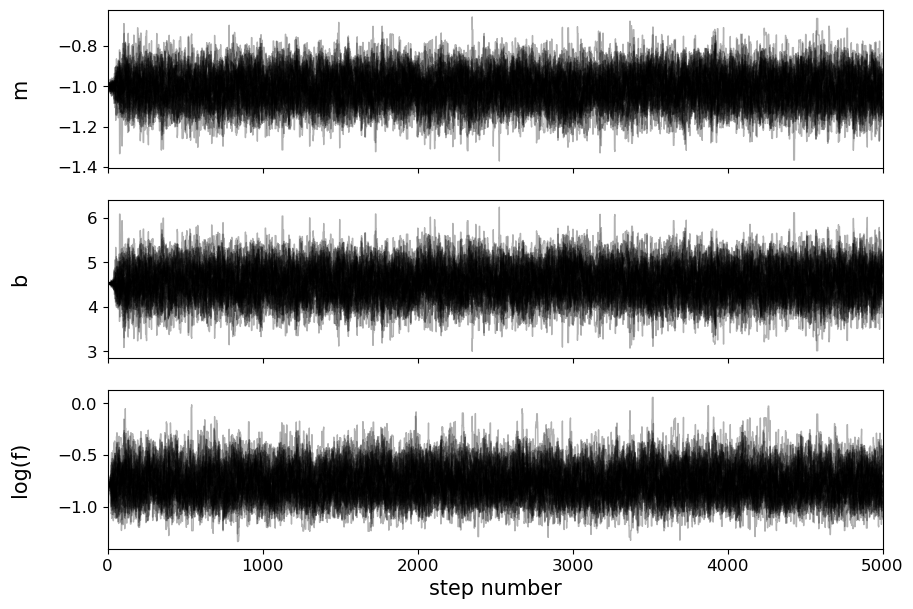

In [12]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [15]:
import corner

(10432, 3)


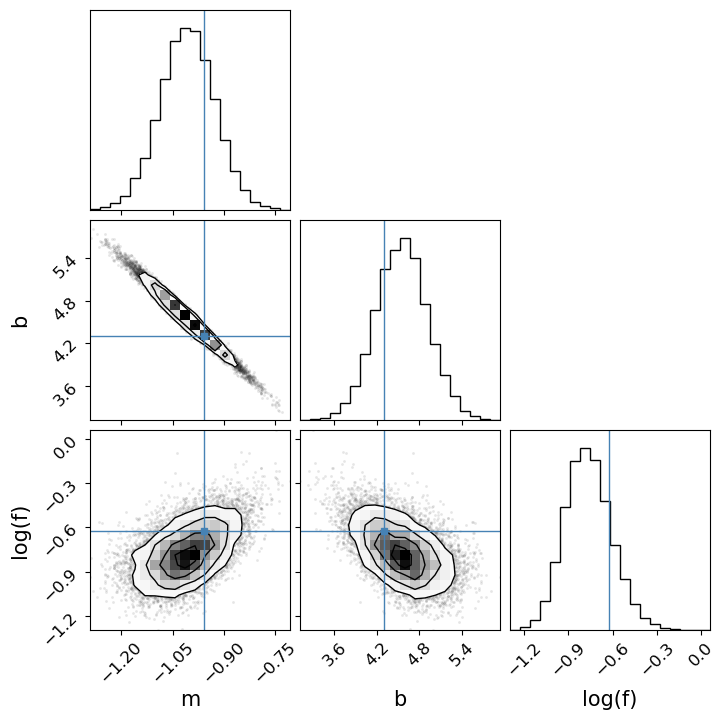

In [22]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

fig = corner.corner(
    flat_samples, labels=labels, truths=[m_true, b_true, np.log(f_true)]
);

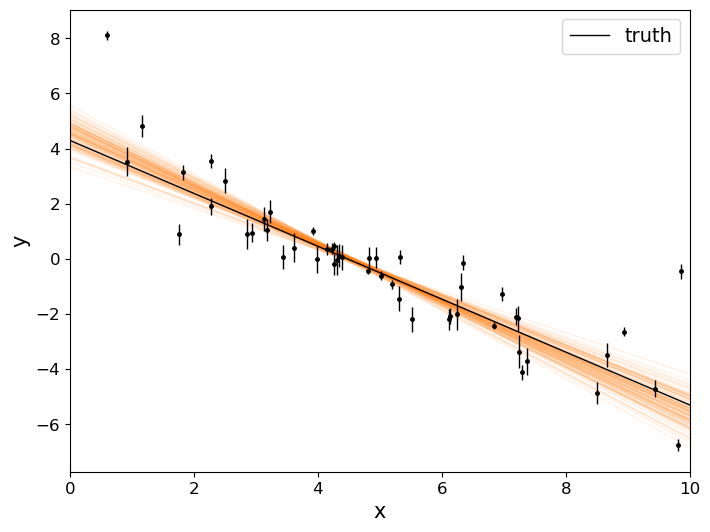

In [23]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");